In [1]:
from itertools import count
from typing import Callable, Any

from record_preprocess import *

cluster_to_color = {
    ClusterName.Cluster8: colors[0],
    ClusterName.Cluster8R: colors[1]
}

cluster_to_label = {
    ClusterName.Cluster8: "Simulator",
    ClusterName.Cluster8R: "Ground Truth"
}

In [2]:
LOAD_UTIL_CONFIG.LOAD_UTIL = True
load_all_play_records(cluster_name_set={ClusterName.Cluster8, ClusterName.Cluster8R})

/Users/purchaser/PycharmProjects/MMKP-solver/data_source.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.most_memory_consumption: int = stats.mode(memories)[0][0]


Data sources loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_KubeShare_2023-03-15-17-39-52/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8R_data_source_phi_static_Tiresias_2023-03-15-17-40-04/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_Kubernetes_2023-03-15-17-40-32/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_MMKP_2023-03-15-17-37-12/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_AFS_2023-03-15-17-40-17/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8R_data_source_phi_static_Kubernetes_2023-03-15-17-40-32/json loaded
json

ClusterName.Cluster8:  [17.05809168 12.2559238  15.14884929 12.73303635 13.13122695 10.16376442]
ClusterName.Cluster8R:  [15.87039495 11.90305337 15.12962153 12.72344845 13.11882016 10.16881983]
ClusterName.Cluster8:  [0.95095066 0.69408042 0.84125217 0.70885276 0.86369536 0.5621606 ]
ClusterName.Cluster8R:  [0.96216342 0.70104483 0.85096322 0.71567484 0.87169183 0.5677425 ]
ClusterName.Cluster8:  [1.0132982  1.31359546 1.10606563 1.16988069 1.29991332 1.63580624]
ClusterName.Cluster8R:  [1.         1.33187902 1.10842743 1.18444704 1.22725607 1.57706963]
ClusterName.Cluster8:  [1.         1.33436501 1.09147934 1.74763456 1.24563043 1.61549939]
ClusterName.Cluster8R:  [1.00753075 1.34363962 1.1043311  1.77333367 1.25372441 1.63069843]


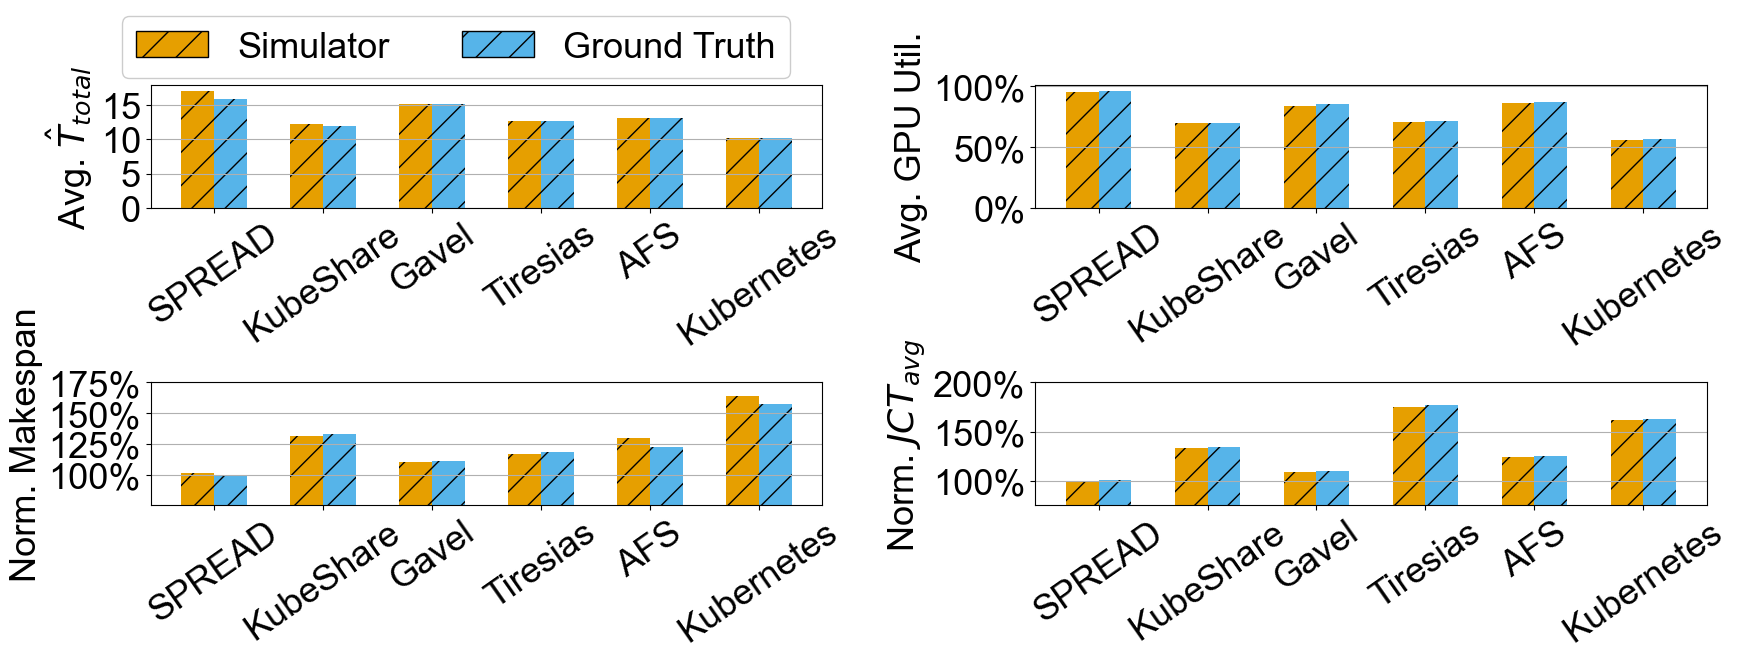

In [3]:

def get_time_series_func(extract_item: Callable[[AssignmentStatistics], Any],
                         scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    scheduler_to_items = defaultdict(list)
    scheduler_to_curr_record_idx = defaultdict(int)
    time_interval *= 1e9
    time_interval = int(time_interval)
    for i in count(0):
        now = i * time_interval
        has_none_zero = False
        for scheduler, record in scheduler_to_record.items():
            idx = scheduler_to_curr_record_idx[scheduler]
            while idx + 1 < len(record.assignment_statistics) and record.assignment_statistics[idx + 1].now < now:
                idx += 1
            if idx >= len(record.assignment_statistics) - 1:
                # break
                # scheduler_to_items[scheduler].append(0)
                continue
            has_none_zero = True
            scheduler_to_curr_record_idx[scheduler] = idx
            assignment_stats = record.assignment_statistics[idx]
            item = extract_item(assignment_stats)
            scheduler_to_items[scheduler].append(item)
        if not has_none_zero:
            break
    return scheduler_to_items


def time_series_profit(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: 2 * assignment_stats.profit, scheduler_to_record,
                                time_interval)


def time_series_comp_util(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.total_comp_util, scheduler_to_record,
                                time_interval)


def time_series_mem_util(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.total_mem_utilization, scheduler_to_record,
                                time_interval)


def time_series_deployed_count(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.deployed_job_size, scheduler_to_record,
                                time_interval)


def plot_avg_time_series_profit_bar(ax):
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  ]
    data_source_name = DataSourceName.DataSourcePhiSta
    cluster_names = [ClusterName.Cluster8, ClusterName.Cluster8R]
    X = np.arange(len(schedulers))
    width = 0.3
    cluster_to_avg_profits = defaultdict(list)
    for i, cluster_name in enumerate(cluster_names):
        scheduler_to_record = dict()
        for scheduler in schedulers:
            play_record = extract_play_record(mode=SessionMode.Trace,
                                              data_source_name=data_source_name,
                                              cluster_name=cluster_name,
                                              scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            scheduler_to_record[scheduler] = play_record
        scheduler_to_profits = time_series_profit(scheduler_to_record)
        for scheduler in schedulers:
            profits = scheduler_to_profits[scheduler]
            profits = list(filter(lambda profit: profit > 4, profits))
            cluster_to_avg_profits[cluster_name].append(np.mean(profits))

    hatch = "/"
    for i, cluster_name in enumerate(cluster_names):
        avg_profits = cluster_to_avg_profits[cluster_name]
        print(f"{cluster_name}: ", np.array(avg_profits))
        ax.bar(
            X + i * width,
            np.array(avg_profits),
            # edgecolor=edgecolor,
            width=width,
            color=cluster_to_color[cluster_name],
            label=cluster_to_label[cluster_name],
            hatch=hatch
        )
    ax.set_xticks(X + (width / 2),
                  [scheduler_to_spec(scheduler_name=s)["label"] for s in schedulers], rotation=35)
    # ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    y_major_loc = plt_ticker.MultipleLocator(base=5)
    ax.yaxis.set_major_locator(y_major_loc)
    ax.set_ylabel('Avg. $\hat{T}_{total}$')
    # ax.set_xlabel('Workloads')
    # fig.tight_layout()
    # fig.legend(loc=(0.1, 0.68), ncol=4)
    # fig.subplots_adjust(top=0.6)
    ax.yaxis.grid(True)
    # save_fig(fig, output_path(f"avg_profit_bar.pdf"))
    # mpl.rcParams.update({'font.size': original_fontsize})

def plot_avg_time_series_util_bar(ax):
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  ]
    data_source_name = DataSourceName.DataSourcePhiSta
    cluster_names = [ClusterName.Cluster8, ClusterName.Cluster8R]
    X = np.arange(len(schedulers))
    width = 0.3
    cluster_to_avg_utils = defaultdict(list)
    for i, cluster_name in enumerate(cluster_names):
        scheduler_to_record = dict()
        for scheduler in schedulers:
            play_record = extract_play_record(mode=SessionMode.Trace,
                                              data_source_name=data_source_name,
                                              cluster_name=cluster_name,
                                              scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            scheduler_to_record[scheduler] = play_record
        scheduler_to_utils = time_series_comp_util(scheduler_to_record)
        for scheduler in schedulers:
            utils = scheduler_to_utils[scheduler]
            utils = list(filter(lambda u: u > 400, utils))
            cluster_to_avg_utils[cluster_name].append(np.mean(utils) / 800)

    hatch = "/"
    for i, cluster_name in enumerate(cluster_names):
        avg_utils = cluster_to_avg_utils[cluster_name]
        print(f"{cluster_name}: ", np.array(avg_utils))
        ax.bar(
            X + i * width,
            np.array(avg_utils),
            # edgecolor=edgecolor,
            width=width,
            color=cluster_to_color[cluster_name],
            label=cluster_to_label[cluster_name],
            hatch=hatch
        )
    ax.set_xticks(X + (width / 2),
                  [scheduler_to_spec(scheduler_name=s)["label"] for s in schedulers], rotation=35)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    y_major_loc = plt_ticker.MultipleLocator(base=0.5)
    ax.yaxis.set_major_locator(y_major_loc)
    ax.set_ylabel('Avg. GPU Util.')
    # ax.set_xlabel('Workloads')
    # fig.tight_layout()
    # fig.legend(loc=(0.1, 0.68), ncol=4)
    # fig.subplots_adjust(top=0.6)
    ax.yaxis.grid(True)
    # save_fig(fig, output_path(f"avg_profit_bar.pdf"))
    # mpl.rcParams.update({'font.size': original_fontsize})


def plot_makespan_bar(ax):
    # original_fontsize = mpl.rcParams["font.size"]
    # mpl.rcParams.update({'font.size': 26})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  ]
    data_source_name = DataSourceName.DataSourcePhiSta
    cluster_names = [ClusterName.Cluster8, ClusterName.Cluster8R]
    X = np.arange(len(schedulers))
    width = 0.3
    cluster_to_makespans = defaultdict(list)
    base = int(1e16)
    for i, cluster_name in enumerate(cluster_names):
        for scheduler in schedulers:
            play_record = extract_play_record(
                mode=SessionMode.Trace,
                data_source_name=data_source_name,
                cluster_name=cluster_name,
                scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            max_completion_time = np.max([done_job.completion_time for done_job in play_record.done_records.values()])
            cluster_to_makespans[cluster_name].append(max_completion_time)
            base = min(base, max_completion_time)

    bottom = 0.75
    hatch = "/"
    for i, cluster_name in enumerate(cluster_names):
        makespans = cluster_to_makespans[cluster_name]
        makespans_normalized = np.array(makespans) / np.array(base)
        print(f"{cluster_name}: ", np.array(makespans_normalized))
        ax.bar(
            X + i * width,
            np.array(makespans_normalized) - bottom,
            width=width,
            color=cluster_to_color[cluster_name],
            label=cluster_to_label[cluster_name],
            hatch=hatch,
            bottom=bottom
        )
    ax.spines['bottom'].set_position(('data', bottom))
    ax.set_xticks(X + (width / 2),
                  [scheduler_to_spec(s)["label"] for s in schedulers], rotation=35)
    ax.set_yticks([1, 1.25, 1.5, 1.75])
    # fig.tight_layout()
    # fig.legend(loc=(0.1, 0.68), ncol=4)
    # fig.subplots_adjust(top=0.6)
    ax.set_ylabel('Norm. Makespan')
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    # save_fig(fig, output_path(f"makespan_bar.pdf"))
    # mpl.rcParams.update({'font.size': original_fontsize})


def plot_JCT_bar(ax):
    # original_fontsize = mpl.rcParams["font.size"]
    # mpl.rcParams.update({'font.size': 26})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  ]
    # fig, ax = plt.subplots(figsize=(16, 4))
    cluster_names = [ClusterName.Cluster8, ClusterName.Cluster8R]
    data_source_name = DataSourceName.DataSourcePhiSta
    X = np.arange(len(schedulers))
    width = 0.3
    cluster_to_JCTs = defaultdict(list)
    base = int(1e16)
    for i, cluster_name in enumerate(cluster_names):
        for scheduler in schedulers:
            play_record = extract_play_record(
                mode=SessionMode.Trace,
                data_source_name=data_source_name,
                cluster_name=cluster_name,
                scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            JCTs = list()
            for done_job in play_record.done_records.values():
                JCT = done_job.completion_time - done_job.submit_time
                JCTs.append(JCT)
            avg_jct = np.mean(JCTs)
            cluster_to_JCTs[cluster_name].append(avg_jct)
            base = min(base, avg_jct)

    bottom = 0.75
    hatch = "/"
    for i, cluster_name in enumerate(cluster_names):
        avgJCTs = cluster_to_JCTs[cluster_name]
        avgJCTs_normalized = np.array(avgJCTs) / np.array(base)
        print(f"{cluster_name}: ", np.array(avgJCTs_normalized))
        ax.bar(
            X + i * width,
            np.array(avgJCTs_normalized) - bottom,
            width=width,
            color=cluster_to_color[cluster_name],
            label=cluster_to_label[cluster_name],
            hatch=hatch,
            bottom=bottom
        )
    ax.spines['bottom'].set_position(('data', bottom))
    ax.set_xticks(X + (width / 2),
                  [scheduler_to_spec(s)["label"] for s in schedulers], rotation=35)
    ax.set_yticks([1, 1.5, 2.0])
    # fig.tight_layout()
    # fig.legend(loc=(0.1, 0.68), ncol=3)
    # fig.subplots_adjust(top=0.6)
    ax.set_ylabel('Norm. $JCT_{avg}$')
    # ax.set_xlabel('Workloads')
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    # save_fig(fig, output_path(f"JCT_bar.pdf"))
    # mpl.rcParams.update({'font.size': original_fontsize})


def plot_time_series_item_for_record(ax, time_series_func, data_source_name: DataSourceName,
                                     scheduler_to_record: Dict[SchedulerName, PlayRecord], y_label, max_item=16,
                                     yticks=None):
    scheduler_to_item = time_series_func(scheduler_to_record, time_interval=60)
    time_point_count = max([len(item) for item in scheduler_to_item.values()])
    # for scheduler, profits in scheduler_to_item.items():
    #     assert len(profits) == time_point_count
    X = np.arange(time_point_count)
    inside_ticks(ax)
    # y_major_loc = plt_ticker.MultipleLocator()
    # ax.yaxis.set_major_locator(y_major_loc)
    major_loc = 60 * 24
    data_source_name_to_multiple_locator = {
        DataSourceName.DataSourcePhiSta: 1 * major_loc,
        DataSourceName.DataSourcePhiSta: 1 * major_loc,
        DataSourceName.DataSourcePhiDyn: 1 * major_loc,
        DataSourceName.DataSourcePhiSta: 1 * major_loc
    }
    multiple_locator = data_source_name_to_multiple_locator[data_source_name]
    x_major_loc = plt_ticker.MultipleLocator(base=multiple_locator)
    x_minor_loc = plt_ticker.MultipleLocator(base=multiple_locator // 4)
    ax.xaxis.set_major_locator(x_major_loc)
    ax.xaxis.set_minor_locator(x_minor_loc)
    ax.xaxis.set_major_formatter(plt_ticker.FuncFormatter(lambda v, pos: int(v / major_loc)))
    if max_item is not None:
        ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    handles = []

    phi_days = int(60 * 24 * 2.5)  # 2.5 days
    ali_days = int(60 * 24 * 1.25)  # 1.25 days
    time_limit = {
        DataSourceName.DataSourcePhiSta: ali_days,
        DataSourceName.DataSourcePhiSta: ali_days,
        DataSourceName.DataSourcePhiSta: phi_days,
        DataSourceName.DataSourcePhiDyn: phi_days
    }[data_source_name]
    for scheduler_name, y_data in scheduler_to_item.items():
        y_data = np.array(y_data)
        if max_item is not None:
            y_data = y_data.clip(max=max_item)
            y_data = y_data / max_item
        spec = scheduler_to_spec(scheduler_name)
        label = spec["label"]
        zorder = spec["zorder"]
        linestyle = spec["linestyle"]
        linewidth = 5
        color = spec["color"]
        X = np.arange(len(y_data))
        if len(X) > time_limit:
            X = X[:time_limit]
            y_data = y_data[:time_limit]
        ax.plot(X, y_data,
                marker=None,
                linestyle=linestyle,
                linewidth=linewidth,
                label=label,
                zorder=zorder,
                color=color,
                )
        handle = mlines.Line2D(
            [], [],
            color=color,
            marker=None,
            linestyle=linestyle,
            label=label,
            zorder=zorder,
            linewidth=linewidth,
        )
        handles.append(handle)
    if yticks is not None:
        ax.set_yticks(yticks)
        # ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_ylabel(y_label)
    ax.set_xlabel('Time (Day)')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(f"{data_source_to_spec(data_source_name)['label']}")
    return handles


def plot_time_series_item_for_all_records(time_series_func, cluster_name, filename, max_item, y_label, yticks=None):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  SchedulerName.SPREAD_PRIME]
    data_source_names = [
        DataSourceName.DataSourcePhiSta,
        DataSourceName.DataSourcePhiSta,
        DataSourceName.DataSourcePhiDyn,
        DataSourceName.DataSourcePhiSta,
    ]
    col = 2
    fig, axes = plt.subplots(2, col, figsize=(16, 9))
    handles = None
    for i, data_source_name in enumerate(data_source_names):
        scheduler_to_record = dict()
        for scheduler in schedulers:
            play_record = extract_play_record(mode=SessionMode.Trace,
                                              data_source_name=data_source_name,
                                              cluster_name=cluster_name,
                                              scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            scheduler_to_record[scheduler] = play_record
        handles = plot_time_series_item_for_record(axes[i // col, i % col],
                                                   time_series_func=time_series_func,
                                                   data_source_name=data_source_name,
                                                   scheduler_to_record=scheduler_to_record,
                                                   max_item=max_item,
                                                   y_label=y_label,
                                                   yticks=yticks)
    fig.tight_layout()
    nrow = 2
    lgd = fig.legend(handles=handles, loc=(0.05, 0.86), ncol=len(handles) // nrow + 1)
    lgd.get_frame().set_alpha(None)
    fig.subplots_adjust(top=0.8)
    save_fig(fig, output_path(filename))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_time_series_items_for_all_records():
    plot_time_series_item_for_all_records(time_series_func=time_series_profit, cluster_name=ClusterName.Cluster64,
                                          filename="time_series_profits.pdf", y_label=r"$\hat{T}_{total}$",
                                          max_item=None, yticks=[0, 30, 60, 90, 120])
    # plot_time_series_item_for_all_records(time_series_func=time_series_mem_util, cluster_name=ClusterName.Cluster10GPUs,
    #                                       filename="time_series_10GPUs_mem.pdf", y_label="Memory Utilization",
    #                                       max_item=1)
    plot_time_series_item_for_all_records(time_series_func=time_series_comp_util,
                                          cluster_name=ClusterName.Cluster64,
                                          filename="time_series_comp.pdf", y_label="GPU Utilization",
                                          max_item=64 * 100)
    # plot_time_series_item_for_all_records(time_series_func=time_series_deployed_count,
    #                                       cluster_name=ClusterName.Cluster64,
    #                                       filename="time_series_placed_job_size.pdf", y_label="Placed Job Size",
    #                                       max_item=None)
def create_verification():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 26})
    fig, axes = plt.subplots(2, 2, figsize=(18, 7))
    plot_avg_time_series_profit_bar(axes[0, 0])
    plot_avg_time_series_util_bar(axes[0, 1])
    plot_makespan_bar(axes[1, 0])
    plot_JCT_bar(axes[1, 1])

    handles = list()

    for i, cluster_name in enumerate([ClusterName.Cluster8, ClusterName.Cluster8R]):
        hatch = "/"
        handle = Patch(
            facecolor=cluster_to_color[cluster_name],
            edgecolor="black",
            label=cluster_to_label[cluster_name],
            hatch=hatch
        )
        handles.append(handle)

    fig.tight_layout()
    nrow = 2
    lgd = fig.legend(handles=handles, loc=(0.07, 0.88), ncol=len(handles) // nrow + 1)
    lgd.get_frame().set_alpha(None)
    fig.subplots_adjust(top=0.86)
    save_fig(fig, output_path(f"simulator_validation.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})



create_verification()